In an October 9, 2017 Slack message (https://choderalab.slack.com/files/U026RHN4X/F7FQ5S002/image_uploaded_from_ios.jpg), John derived the following low-order expansion:

Starting point: the nested expectation we ended up attempting to estimate directly using a plug-in Monte Carlo method:
$$\newcommand{DKL}{\mathcal{D}_\text{KL}} \DKL(\rho \| \pi) = \left\langle \ln \langle e^{-w} \rangle_{x_0; \Lambda} \right\rangle_\rho$$

End-point: $$\begin{aligned}
\DKL(\rho \| \pi) &\approx \left\langle \frac{\langle \Delta w ^2 \rangle_{x_0; \Lambda}}{2} \right\rangle_\rho - \langle w \rangle_{\rho; \Lambda}\\
&= \frac{1}{2} \langle \Delta w^2 \rangle_\rho - \langle w \rangle_{\rho; \Lambda}\end{aligned}$$
which is a low order approximation when $\langle \Delta w^2 \rangle < 1$...

We had abandoned this estimator when we checked the variance of the work distributions for the `WaterBox`, and found they were much larger than 1 for timesteps of interest (e.g. for OVRVO at 5fs, the 100-step work distribution at steady-state had a variance of ~15-20).

We have since switched from the `WaterBox` testsystem to a more-manageable `WaterCluster` testsystem, and we have a ton of work samples to look at. Also, the plug-in estimator of that nested expectation is biased at large stepsizes and was super expensive.

Thus, I'm revisiting the estimator based on the low-order expansion.

In [1]:
import numpy as np
def low_order_estimator(works):
    return 0.5 * np.var(works) - np.mean(works)

In [2]:
# so, we have near-equilibrium results all in one place:
from pickle import load
from simtk import unit

with open('result_summary.pkl', 'rb') as f:
    near_eq_result_summary = load(f)
    
# and nested-MC estimates in two places:

# (1) the samples collected in parallel for dt >= 5fs
from glob import glob
fnames = glob('../data/tight_tolerance_results_parallel_5x/summary_*.pkl')
results = []
for fname in fnames:
    with open(fname, 'rb') as f:
        results.append(load(f))

In [3]:
#near_eq_result_summary

In [4]:
Ws = results[-1][1]['Ws']

In [5]:
works = np.hstack(Ws)
works.shape

(5544350,)

In [6]:
low_order_estimator(works)

0.18277783294098088

In [7]:
from tqdm import tqdm
np.random.seed(0)
low_order_estimates = []
low_order_uncs = []
variances = []

n_bootstrap_samples = 100
for result in tqdm(results):
    Ws = result[1]['Ws']
    works = np.hstack(Ws)
    
    estimates = []
    for _ in range(n_bootstrap_samples):
        
        works_ = works[np.random.randint(0,len(works),5000)]
        estimates.append(low_order_estimator(works_))
    
    variances.append(np.var(works))
    low_order_estimates.append(np.mean(estimates))
    low_order_uncs.append(np.std(estimates))

100%|██████████| 56/56 [00:08<00:00,  7.71it/s]


In [8]:
np.mean(variances)

nan

In [9]:
variances = np.array(variances)

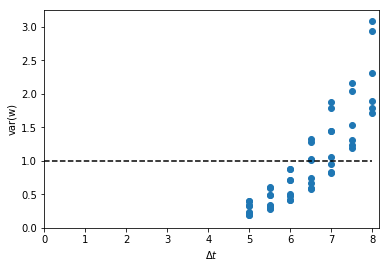

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
dts = []
for result in results:
    dts.append(result[0][1].value_in_unit(unit.femtosecond))
plt.scatter(dts, variances)
plt.ylim(0,)
plt.xlim(0,)
plt.hlines(1,0,max(dts), linestyles='--')
plt.xlabel('$\Delta t$')
plt.ylabel('var(w)')

In [11]:
variances_ = variances[np.isfinite(variances)]

(array([ 15.,  11.,   7.,   6.,   3.,   5.,   2.,   1.,   0.,   2.]),
 array([ 0.19091476,  0.48060109,  0.77028743,  1.05997377,  1.3496601 ,
         1.63934644,  1.92903278,  2.21871912,  2.50840545,  2.79809179,
         3.08777813]),
 <a list of 10 Patch objects>)

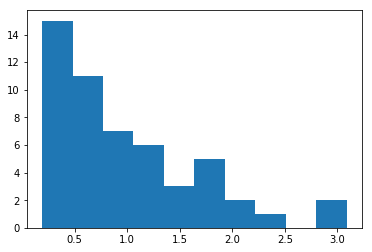

In [12]:
plt.hist(variances_)

In [13]:
color_dict = {'ORVRO': 'light blue', 'OVRVO': 'green', 'RVOVR': 'orange', 'VRORV': 'purple'}

In [14]:
near_eq_result_summary['ORVRO']['configuration']

{'dts': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
         7. ,  7.5,  8. ]),
 'near_eq_estimates': array([  8.00077870e-05,   4.91504163e-04,   1.12361893e-03,
          2.44676924e-03,   4.86616597e-03,   8.79781099e-03,
          1.46829689e-02,   2.47651904e-02,   3.39909973e-02,
          5.13262390e-02,   7.44515896e-02,   2.02990962e-01,
          2.74483269e-01,   3.71068616e-01]),
 'near_eq_uncertainty': array([  1.02918651e-05,   4.37785342e-05,   1.04265396e-04,
          1.92463852e-04,   3.11145761e-04,   4.63432987e-04,
          6.53013257e-04,   8.83595724e-04,   1.15805302e-03,
          1.47274150e-03,   1.84307263e-03,   3.47438453e-03,
          4.40143306e-03,   5.85694124e-03])}

In [15]:
from simtk import unit
near_eq_estimates = []
near_eq_uncs = []
for result in results:
    scheme, dt, marginal, testsystem = result[0]
    dts = near_eq_result_summary[scheme][marginal]['dts']
    ind = np.argmin(np.abs(dts - (dt.value_in_unit(unit.femtosecond))))
    
    
    near_eq_estimates.append(near_eq_result_summary[scheme][marginal]['near_eq_estimates'][ind])
    near_eq_uncs.append(near_eq_result_summary[scheme][marginal]['near_eq_uncertainty'][ind])

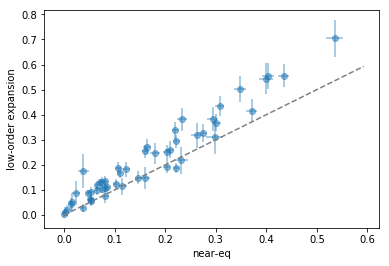

In [16]:
plt.scatter(near_eq_estimates, low_order_estimates, alpha=0.5)
plt.errorbar(near_eq_estimates, low_order_estimates,
             xerr=1.96 * np.array(near_eq_uncs), yerr=1.96 * np.array(low_order_uncs),
             fmt='none', alpha=0.5)
x_ = np.linspace(np.min(near_eq_estimates), np.max(near_eq_estimates))
plt.plot(x_, x_, '--', color='grey')
plt.xlabel('near-eq')
plt.ylabel('low-order expansion')
#plt.xscale('log')
#plt.yscale('log')

Okay cool -- so it looks like the low-order expansion is producing *higher* estimates than the near-equilibrium approximation...

We know that the nested Monte Carlo *under-estimates* the KL divergence, and the severity of this under-estimation increases with $\sigma_\text{inner-loop}$ -- Figure 6 currently compares the near-equilibrium approximation to a known under-estimate.

This could be informative to add to Figure 6 or an appendix, especially if we have a good idea whether this low-order approximation should be an over-estimate or under-estimate...